
# Utforskende dataanalyse av miljødata fra NASA og Frost

Denne notebooken dokumenterer prosessen med å analysere sammenslåtte miljødata fra NASA og Frost. Formålet er å oppnå en dypere forståelse av datastrukturen, statistiske egenskaper, sammenhenger og sesongmønstre før eventuell prediktiv modellering.

Datasettet inneholder daglige observasjoner fra 2020 til 2025 og omfatter variabler som temperatur, luftfuktighet, vind, trykk, solinnstråling og mer. Analysen gir innsikt i hvordan disse variablene fordeler seg, varierer gjennom året, og påvirker hverandre.

---

### Hovedsteg i notebooken:

1. **Import og klargjøring av data**
   Leser inn det rensede datasettet, konverterer datoer, fjerner irrelevante kolonner og gir oversikt over datastrukturen.

2. **Statistisk oppsummering**
   Skriver ut gjennomsnitt, median, standardavvik, varians og ekstremverdier for hver miljøvariabel. Viser også årlige og månedlige temperaturgjennomsnitt.

3. **Korrelasjonsanalyse**
   Utfører en enkel Pearson korrelasjon mellom utvalgte variabler for å undersøke lineære sammenhenger.

4. **Fordeling og sesongvariasjon**
   Visualiserer fordelingen av nedbør, vind og trykk, samt månedlige gjennomsnitt og variasjon for flere miljøvariabler.

5. **Sesongdekomponering**
   Dekomponerer tidsserier for utvalgte variabler i trend, sesong og restledd for å identifisere langtidstendenser og sesongmønstre.

6. **Korrelasjonsmatrise**
   Viser sammenhenger mellom alle numeriske variabler med en heatmap-basert korrelasjonsmatrise.

---

### Om datasettet

Datasettet er allerede renset og standardisert, og inneholder kun numeriske variabler. Det krever derfor ingen ytterligere behandling for å muliggjøre kvantitativ analyse og visualisering. All data er hentet fra åpne API-kilder og koblet sammen basert på dato.

---

### Mål

Notebooken har som mål å legge et analytisk grunnlag for videre modellering ved å avdekke strukturer og sammenhenger i dataene. Det legges vekt på reproduserbarhet, tydelig koding og visuell formidling av innsikter.


## Import og klargjøring av data

Laster inn nødvendige biblioteker og leser det rensede datasettet. Konverterer dato, sorterer kronologisk og viser en oversikt over datastrukturen.


In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


# Les direkte fra sti
df = pd.read_csv("../data/clean/merged_data.csv")
# Konverter 'Date'-kolonnen til datetime
df['Date'] = pd.to_datetime(df['Date'])
# Sorter og reset index
df = df.sort_values('Date').reset_index(drop=True)

# Sjekk format og første rader
df.info()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1853 non-null   datetime64[ns]
 1   Temperature        1853 non-null   float64       
 2   Wind_Speed         1853 non-null   float64       
 3   Wind_Direction     0 non-null      float64       
 4   Precipitation      1853 non-null   float64       
 5   Humidity           1853 non-null   int64         
 6   Pressure           1853 non-null   float64       
 7   Unnamed:_0         1853 non-null   int64         
 8   ALLSKY_SFC_SW_DWN  1853 non-null   float64       
 9   TS                 1853 non-null   float64       
 10  QV2M               1853 non-null   float64       
 11  PS                 1853 non-null   float64       
 12  ComfortIndex       1853 non-null   float64       
dtypes: datetime64[ns](1), float64(10), int64(2)
memory usage: 188.3

,Date,Temperature,Wind_Speed,Wind_Direction,Precipitation,Humidity,Pressure,Unnamed:_0,ALLSKY_SFC_SW_DWN,TS,QV2M,PS,ComfortIndex
0,2020-01-01,7.2,2.2,NaN,0.0,81,1016.3,0,0.15,-1.10,3.53,98.39,7.96
1,2020-01-02,1.7,3.8,NaN,0.0,85,1005.9,1,0.22,0.78,4.15,97.39,2.76
2,2020-01-03,5.6,4.7,NaN,0.0,64,995.0,2,0.35,0.34,3.88,96.34,7.36
3,2020-01-05,-0.4,1.7,NaN,0.0,85,1018.7,4,0.12,-3.02,3.03,98.55,0.83
4,2020-01-08,5.6,4.0,NaN,0.4,74,998.7,7,0.44,1.26,4.24,96.72,6.87


## Statistisk oppsummering

Først fjerner vi kolonner som ikke er relevante for analysen, som en indekskolonne og vindretning, og lager en liste med de gjenværende numeriske variablene. Deretter beregner vi grunnleggende statistiske mål for hver av disse variablene: gjennomsnitt, median, standardavvik, varians, minimum og maksimum. Dette gir en rask forståelse av fordelingen og variasjonen i dataene.

I tillegg ser vi nærmere på temperatur, ved å vise gjennomsnittlig temperatur per år og per måned. Dette hjelper oss med å identifisere langsiktige trender og sesongmønstre i temperaturutviklingen.


In [2]:
# Fjern irrelevante kolonner
exclude = ['Unnamed:_0', 'Wind_Direction']
data_cols = [col for col in df.columns if col not in exclude + ['Date']]

# Statistisk oppsummering
print("### Statistisk oppsummering per variabel ###\n")
for col in data_cols:
    print(f"--- {col} ---")
    print(f"  Gjennomsnitt:     {df[col].mean():.2f}")
    print(f"  Median:           {df[col].median():.2f}")
    print(f"  Standardavvik:    {df[col].std():.2f}")
    print(f"  Varians:          {df[col].var():.2f}")
    print(f"  Min:              {df[col].min():.2f}")
    print(f"  Maks:             {df[col].max():.2f}\n")

# Ekstra analyse: Årlige og månedlige gjennomsnitt for temperatur
if 'Temperature' in df.columns:
    print("### Årlige gjennomsnittstemperaturer ###")
    df['Year'] = df['Date'].dt.year
    yearly_temp = df.groupby('Year')['Temperature'].mean()
    print(yearly_temp.round(2).to_string())
    
    print("\n### Månedlige gjennomsnittstemperaturer ###")
    monthly_avg_temp = df.groupby(df['Date'].dt.to_period('M'))['Temperature'].mean()
    print(monthly_avg_temp.round(2).to_string())


### Statistisk oppsummering per variabel ###

--- Temperature ---
  Gjennomsnitt:     7.51
  Median:           7.20
  Standardavvik:    7.57
  Varians:          57.31
  Min:              -18.90
  Maks:             25.40

--- Wind_Speed ---
  Gjennomsnitt:     2.67
  Median:           2.50
  Standardavvik:    1.13
  Varians:          1.27
  Min:              0.60
  Maks:             8.40

--- Precipitation ---
  Gjennomsnitt:     2.50
  Median:           0.10
  Standardavvik:    5.56
  Varians:          30.95
  Min:              0.00
  Maks:             57.20

--- Humidity ---
  Gjennomsnitt:     74.69
  Median:           77.00
  Standardavvik:    16.51
  Varians:          272.44
  Min:              33.00
  Maks:             100.00

--- Pressure ---
  Gjennomsnitt:     1011.21
  Median:           1011.80
  Standardavvik:    11.92
  Varians:          141.98
  Min:              960.70
  Maks:             1047.50

--- ALLSKY_SFC_SW_DWN ---
  Gjennomsnitt:     2.16
  Median:           2.06


## Korrelasjonsanalyse

Denne funksjonen beregner Pearson korrelasjonskoeffisient mellom to variabler for å undersøke om det finnes en lineær sammenheng mellom dem.

Verdien r forteller hvor sterk og i hvilken retning sammenhengen er (fra -1 til 1), mens p-verdien sier noe om hvor statistisk signifikant denne sammenhengen er (lav p-verdi tyder på at korrelasjonen ikke skyldes tilfeldigheter).

I eksempelet ser vi på sammenhengen mellom Temperatur og TS (bakketemperatur), som antas å være nært knyttet til hverandre. Funksjonen sørger for at manglende verdier ikke forstyrrer analysen ved å fjerne NaN før beregningen.

In [3]:
# enkel korrelasjonsanalyse

def correlation_analysis(col1, col2):
    r, p = stats.pearsonr(df[col1].dropna(), df[col2].dropna())
    print(f"Pearson korrelasjon ({col1} vs {col2}): r = {r:.3f}, p = {p:.3e}")
    return r, p

# Eksempel: Temperatur vs TS
ec1, p1 = correlation_analysis('Temperature', 'TS') if 'TS' in df.columns else (None, None)


Pearson korrelasjon (Temperature vs TS): r = 0.919, p = 0.000e+00


## Fordeling og sesongvariasjon

Vi begynner med å visualisere fordelingen av tre sentrale variabler: nedbør, vindstyrke og lufttrykk. Histogrammene gir innsikt i hvor ofte ulike verdier forekommer, og hjelper oss å identifisere skjevheter, typiske nivåer og ekstreme verdier.

Deretter analyserer vi hvordan ulike miljøvariabler varierer gjennom året. Vi legger til en Month-kolonne, og beregner månedlig gjennomsnitt og standardavvik for temperatur, luftfuktighet, nedbør, vind og solinnstråling. Dette visualiseres i linjediagrammer som viser både typiske verdier og hvor mye de varierer fra måned til måned.

Denne analysen gir verdifull informasjon om sesongmønstre og naturlig variasjon i vær- og klimaforhold.


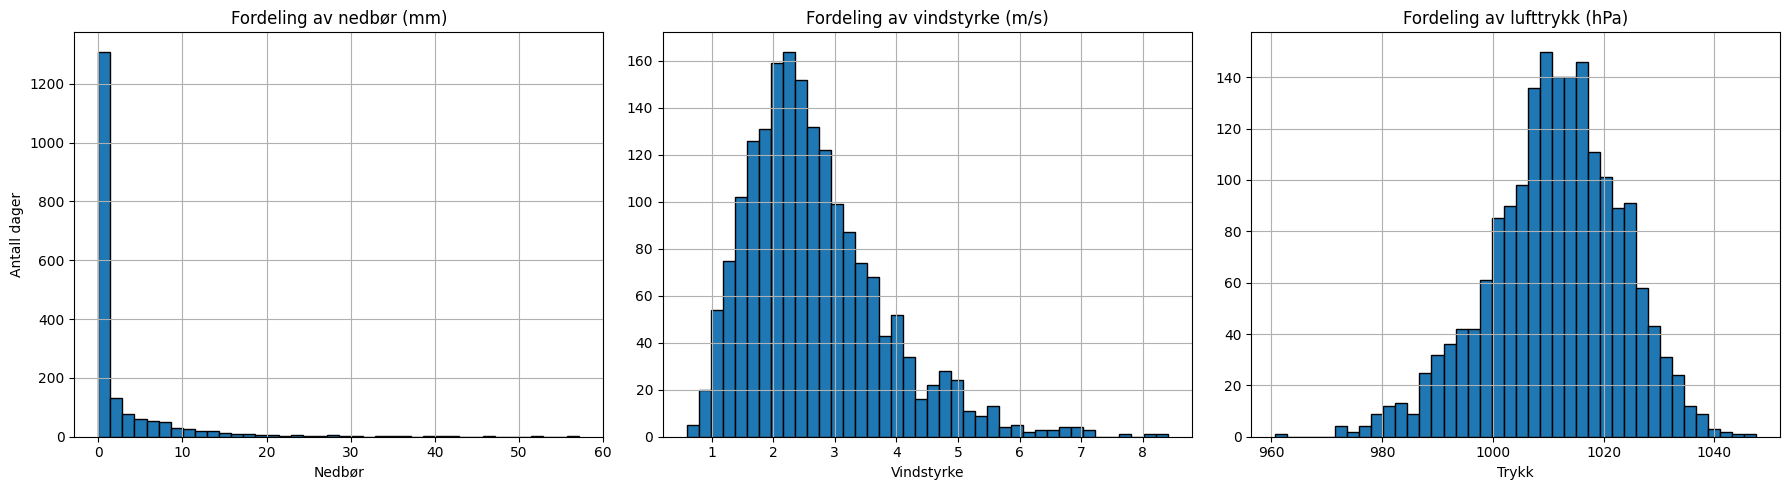

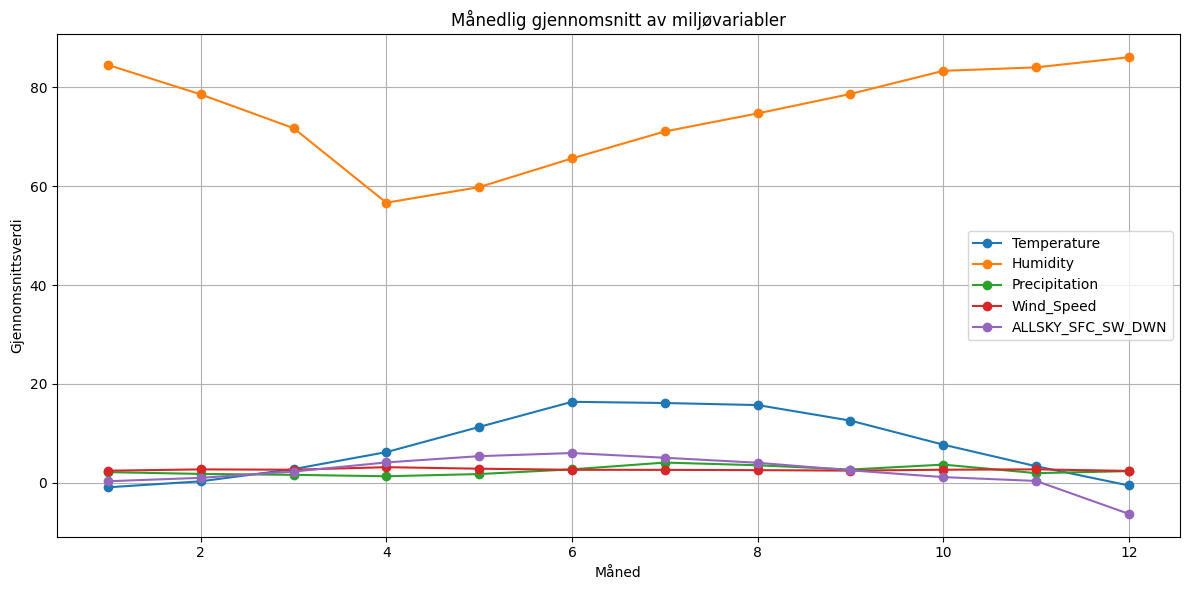

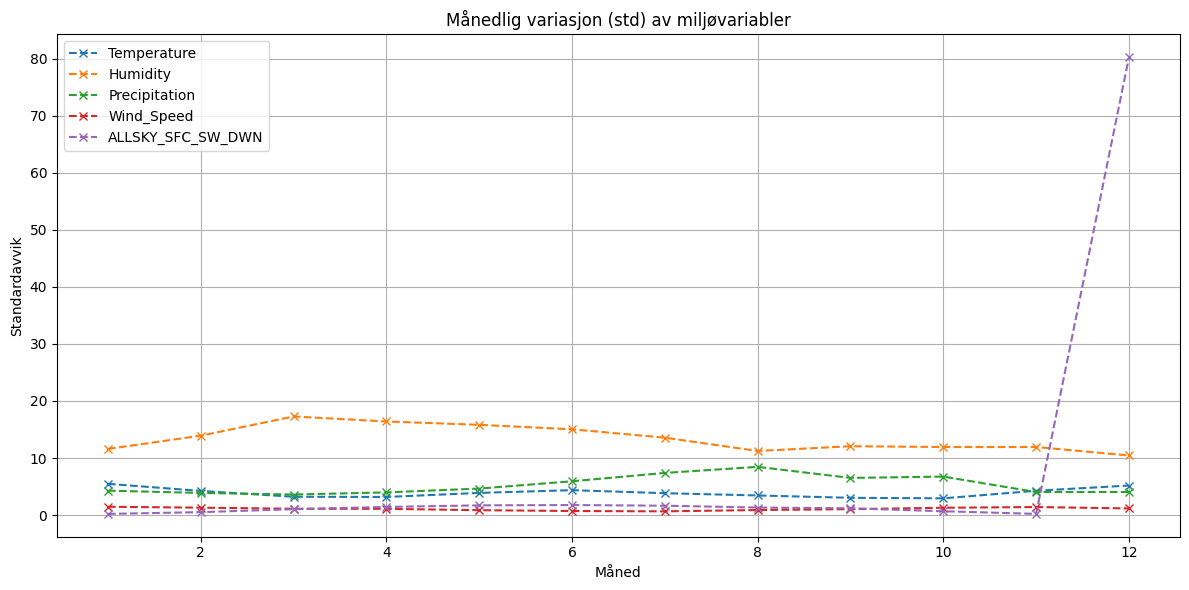

In [4]:
# Sørg for at 'Date' er i datetime-format
df['Date'] = pd.to_datetime(df['Date'])

# Miljøvariabler for analyse
miljøkolonner = ['Temperature', 'Humidity', 'Pressure', 'Precipitation', 'Wind_Speed',
                 'ALLSKY_SFC_SW_DWN', 'TS', 'QV2M', 'PS']

# Histogrammer for tre utvalgte variabler
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

df['Precipitation'].hist(ax=axs[0], bins=40, edgecolor='black')
axs[0].set_title("Fordeling av nedbør (mm)")
axs[0].set_xlabel("Nedbør")
axs[0].set_ylabel("Antall dager")

df['Wind_Speed'].hist(ax=axs[1], bins=40, edgecolor='black')
axs[1].set_title("Fordeling av vindstyrke (m/s)")
axs[1].set_xlabel("Vindstyrke")

df['Pressure'].hist(ax=axs[2], bins=40, edgecolor='black')
axs[2].set_title("Fordeling av lufttrykk (hPa)")
axs[2].set_xlabel("Trykk")

plt.tight_layout()
plt.show()

# Legg til månedskolonne
df['Month'] = df['Date'].dt.month

# Månedlig gjennomsnitt
monthly_avg = df.groupby('Month')[['Temperature', 'Humidity', 'Precipitation', 'Wind_Speed', 'ALLSKY_SFC_SW_DWN']].mean()

# Månedlig standardavvik (for å se variasjon)
monthly_std = df.groupby('Month')[['Temperature', 'Humidity', 'Precipitation', 'Wind_Speed', 'ALLSKY_SFC_SW_DWN']].std()

# Plot månedlig gjennomsnitt
plt.figure(figsize=(12, 6))
monthly_avg.plot(marker='o', title="Månedlig gjennomsnitt av miljøvariabler", ax=plt.gca())
plt.xlabel("Måned")
plt.ylabel("Gjennomsnittsverdi")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot månedlig standardavvik
plt.figure(figsize=(12, 6))
monthly_std.plot(marker='x', linestyle='--', title="Månedlig variasjon (std) av miljøvariabler", ax=plt.gca())
plt.xlabel("Måned")
plt.ylabel("Standardavvik")
plt.grid(True)
plt.tight_layout()
plt.show()


## Sesongdekomponering

I denne delen analyserer vi sesongmønstre og trender i hver miljøvariabel ved hjelp av sesongdekomponering. Dette gir innsikt i hvordan en variabel utvikler seg over tid, og skiller mellom tre komponenter: trend, sesongvariasjon og tilfeldige avvik (restledd).

Først sørger vi for at datoen brukes som indeks, og at dataseriene har daglig frekvens. Vi filtrerer bort variabler med for lite datagrunnlag (mindre enn 2 år), og for variabelen ALLSKY_SFC_SW_DWN fjerner vi uteliggere basert på interkvartilområdet (IQR) for å få renere signal.

Manglende verdier fylles inn ved hjelp av lineær interpolasjon, og deretter brukes seasonal_decompose() fra statsmodels for å bryte ned hver tidsserie. Resultatet visualiseres med separate plott for trend, sesong og residual, som gjør det lettere å forstå strukturen i dataene over tid

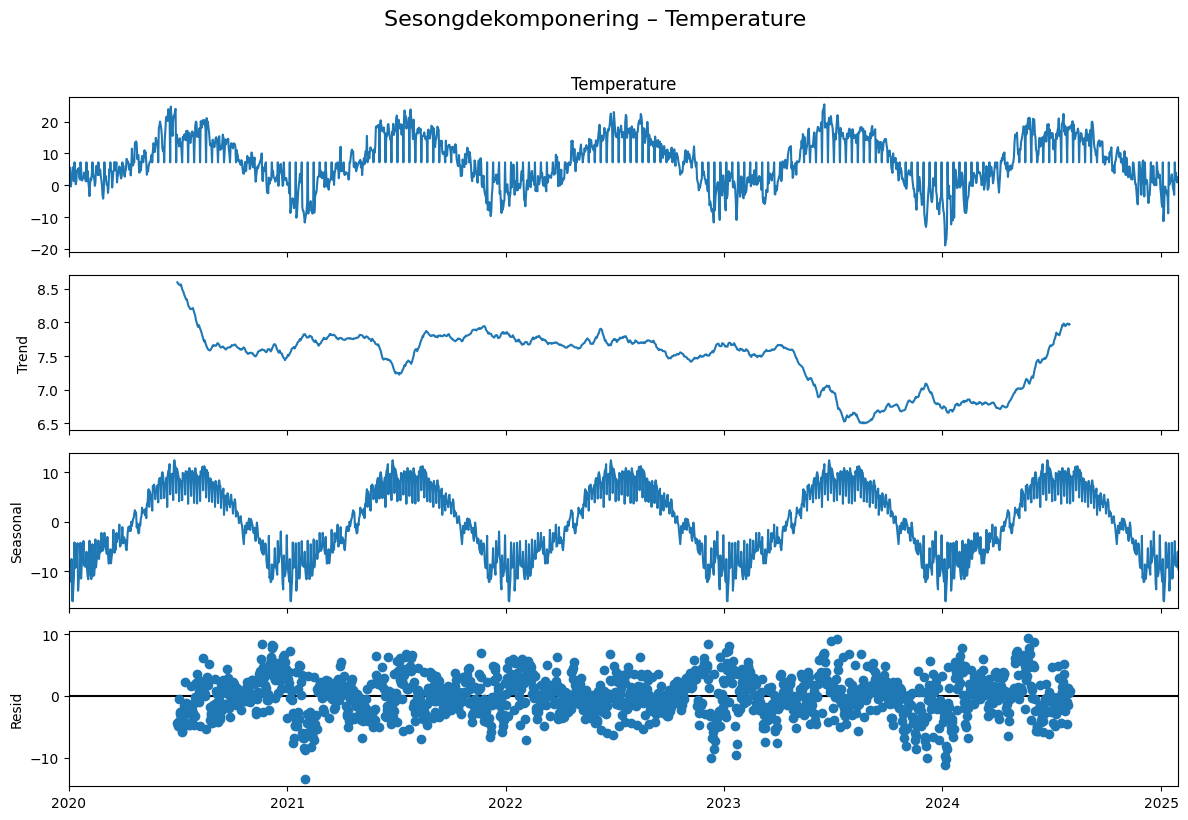

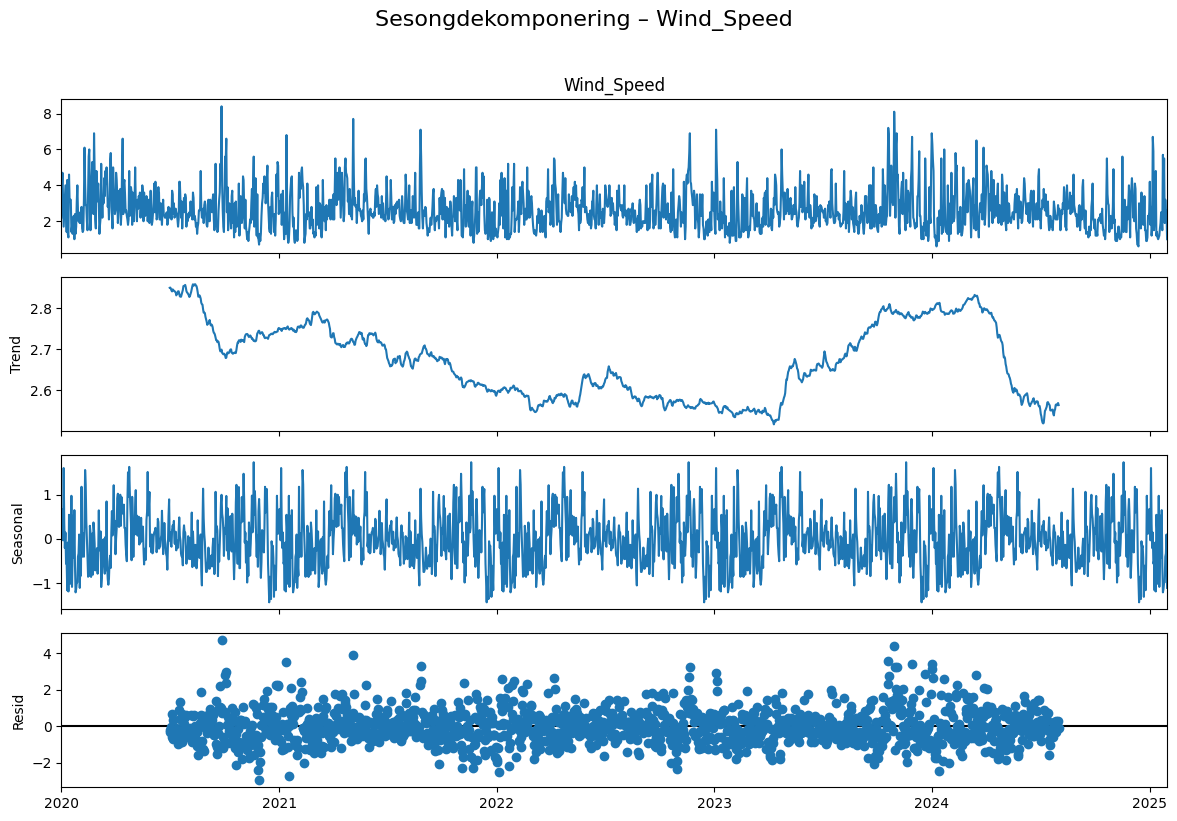

Skipper Wind_Direction – for lite data.


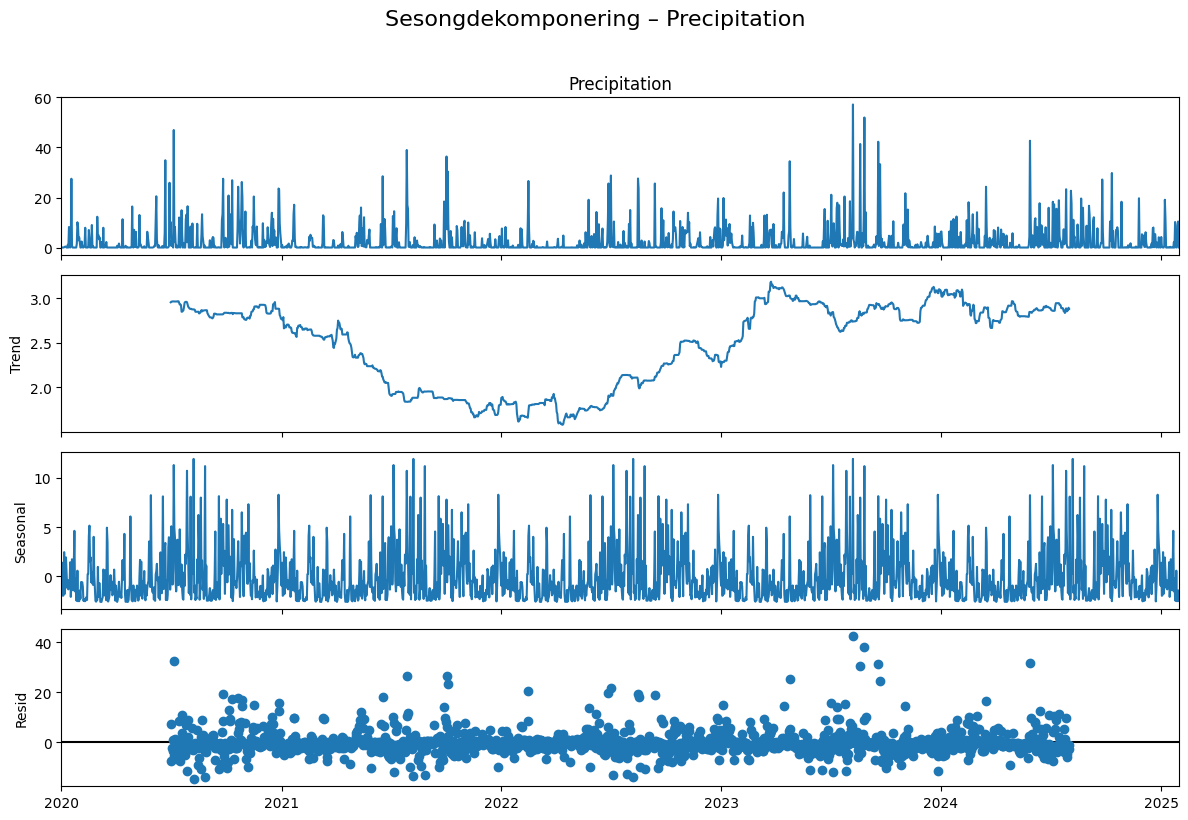

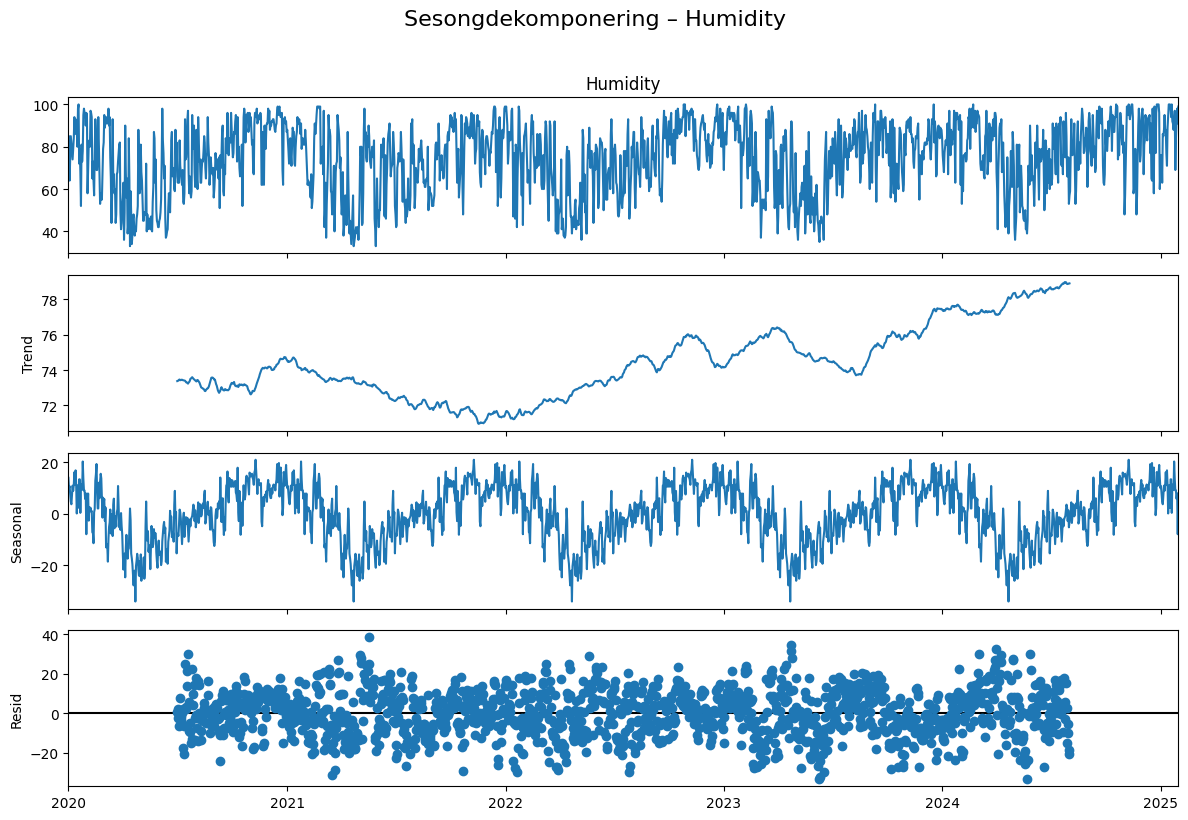

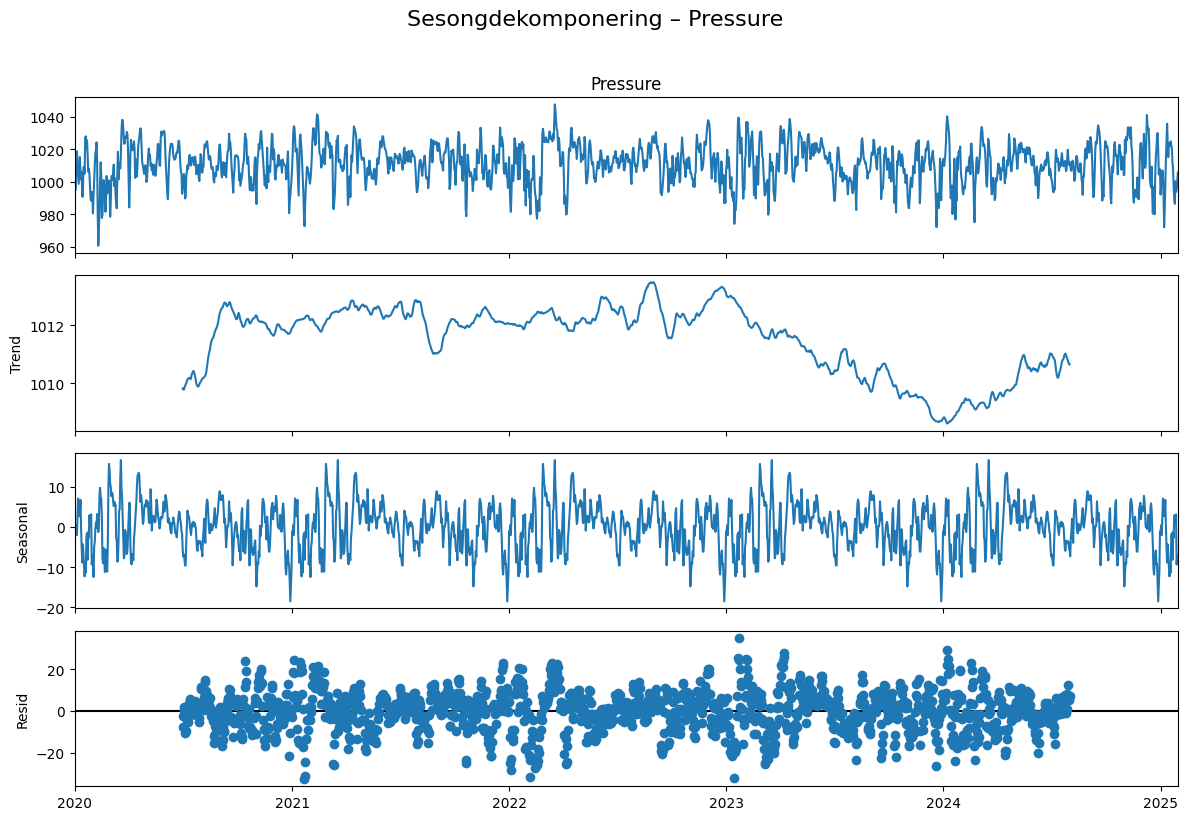

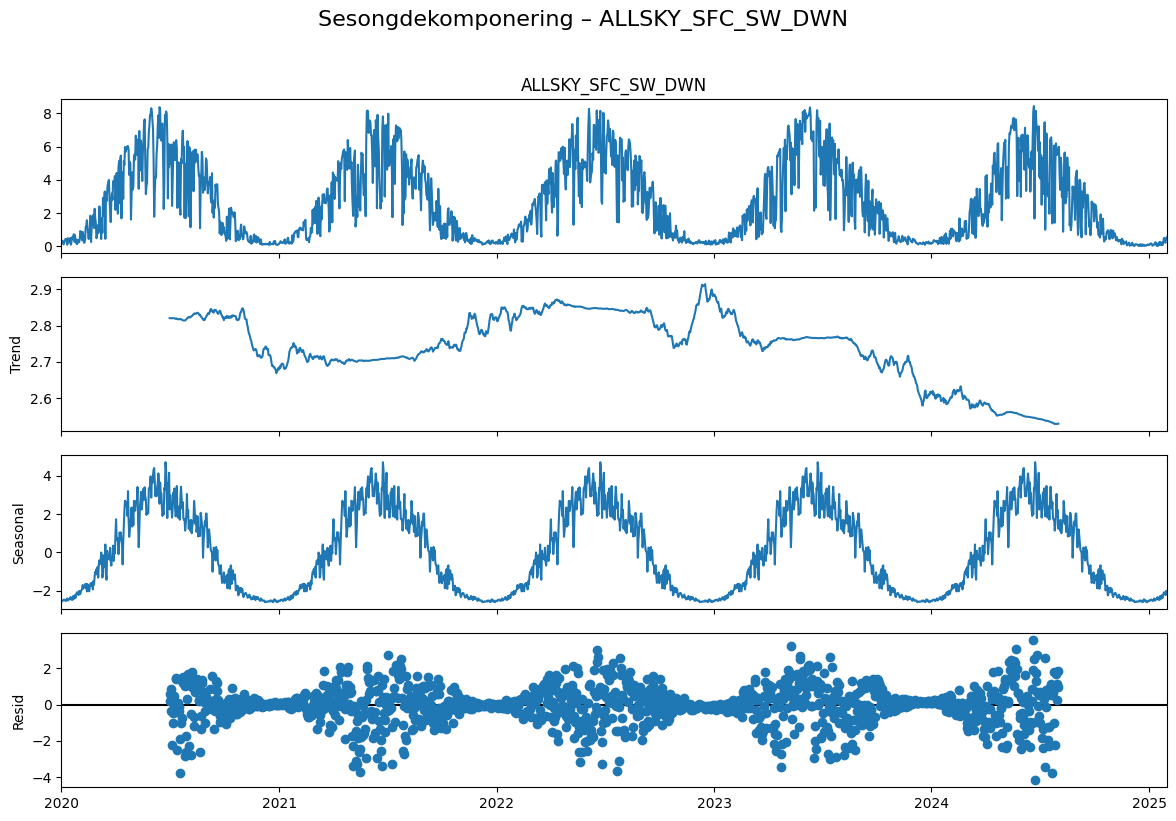

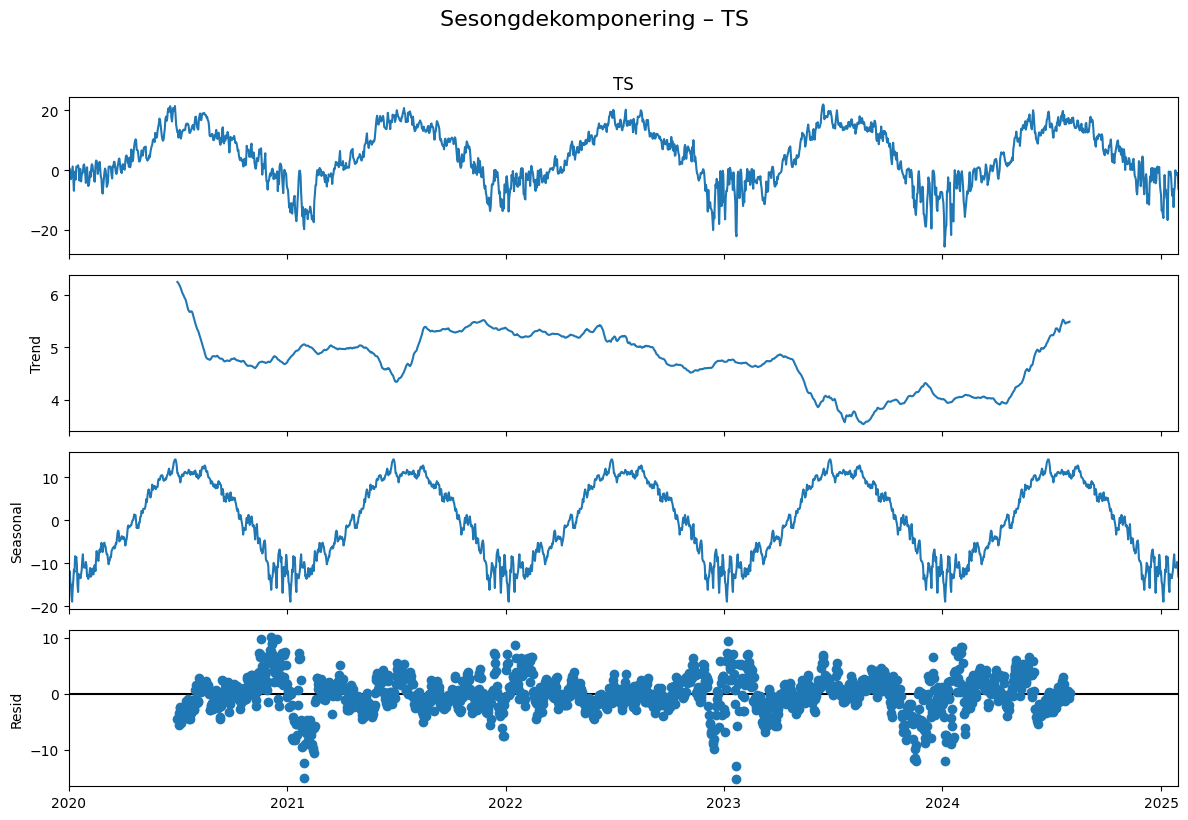

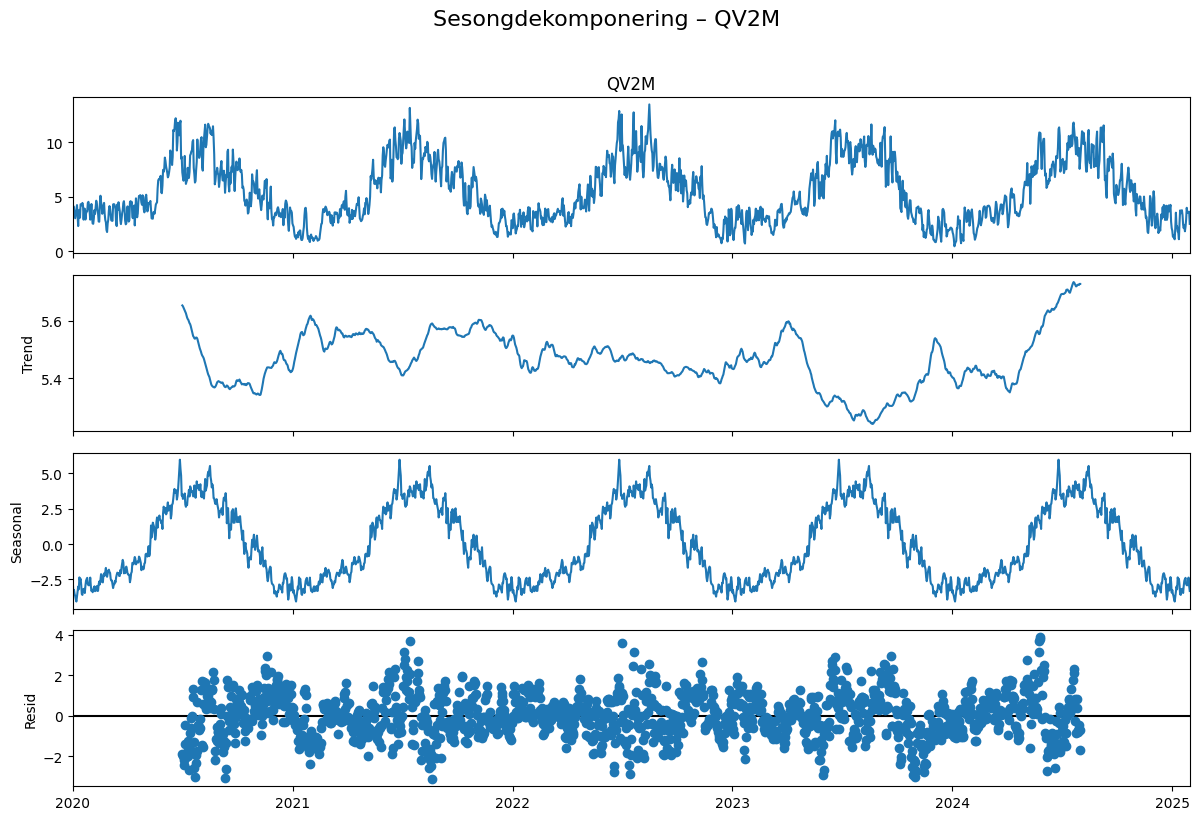

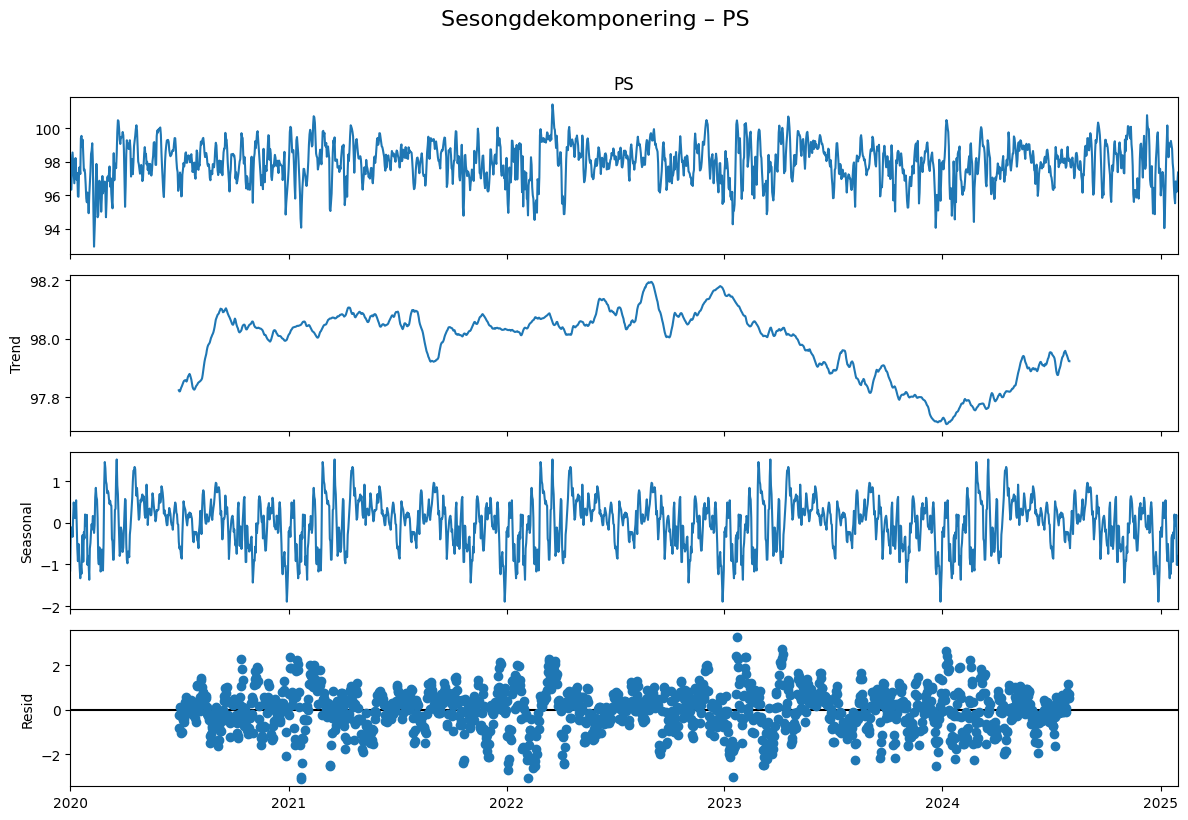

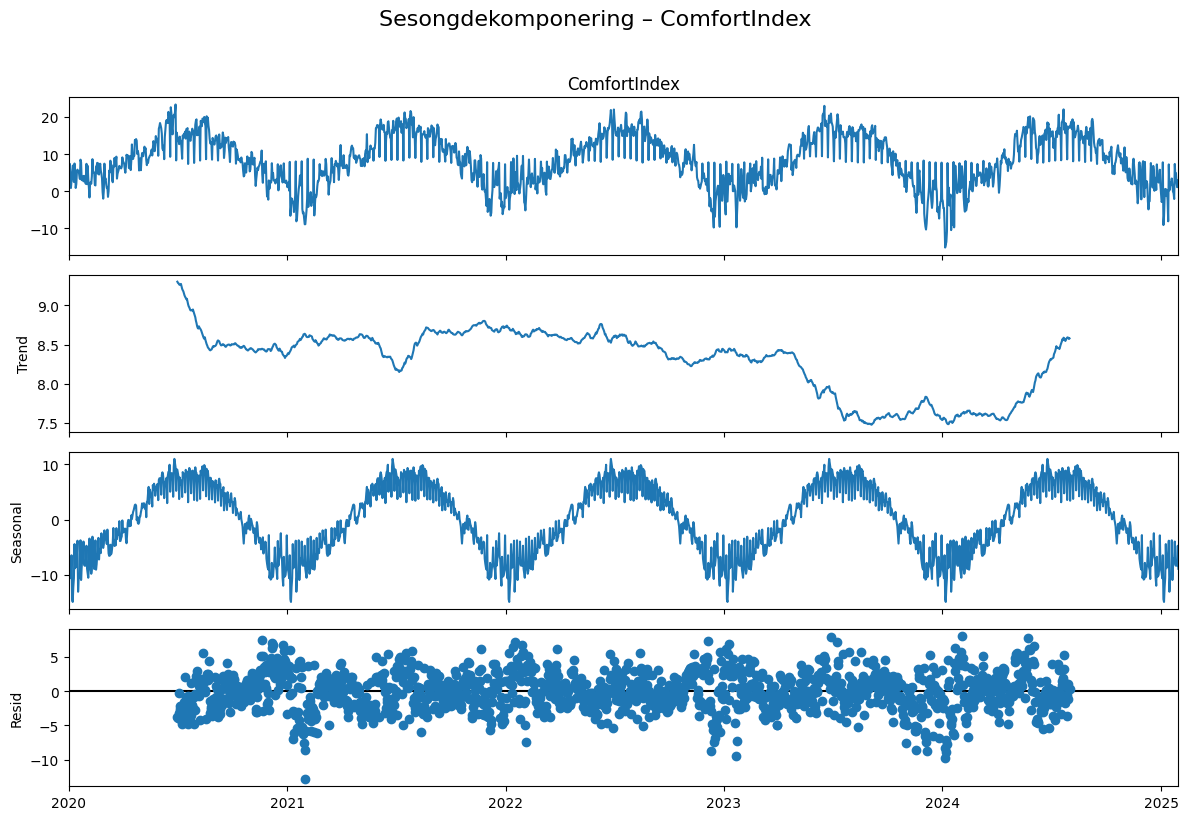

In [5]:
# Sørg for korrekt formatering
df = pd.read_csv("../data/clean/merged_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

# Kolonner vi vil analysere
vars_available = [col for col in df.columns if col != 'Unnamed:_0']

# Decompose hver variabel
for col in vars_available:
    series = df[col].copy()

    # Hopp over hvis for få datapunkter
    if series.dropna().shape[0] < 730:  # 2 år som minimum for decomposing
        print(f"Skipper {col} – for lite data.")
        continue

    # Fjern outliers for ALLSKY_SFC_SW_DWN
    if col == 'ALLSKY_SFC_SW_DWN':
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        upper = q3 + 1.5 * iqr
        lower = q1 - 1.5 * iqr
        series = series[(series >= lower) & (series <= upper)]

    # Interpoler og sett frekvens
    daily = series.asfreq('D').interpolate()

    # Kjør dekomponering
    try:
        decomp = seasonal_decompose(daily, model='additive', period=365)
        fig = decomp.plot()
        fig.set_size_inches(12, 8)
        plt.suptitle(f"Sesongdekomponering – {col}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
    except ValueError as e:
        print(f"Kunne ikke dekomponere {col}: {e}")


## Korrelasjonsmatrise

Et heatmap som viser sammenhengen mellom alle numeriske variabler i datasettet. Matrisen bruker Pearson korrelasjon og viser hvor sterkt to variabler henger sammen, med verdier fra -1 (negativ sammenheng) til 1 (positiv sammenheng).

Fargekartet gjør det enkelt å identifisere både sterke og svake korrelasjoner, og kan gi pekepinn på hvilke variabler som påvirker hverandre

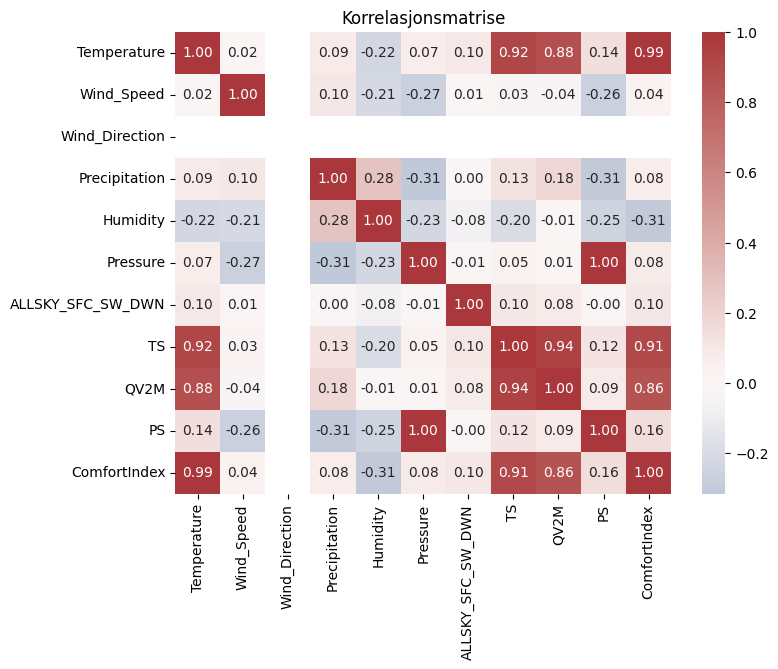

In [6]:
corr = df[vars_available].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Korrelasjonsmatrise')
plt.show()